# Upgraded U-net model

In this notebook we build and upgraded CNN (U-net), train it, generate some figures and save the model to disk
Compared to the benchmark model, this one uses leaky ReLU instead of ReLU, batchnormalization within each convolution block, tanh activation function at the output, L1 loss instead L2, minibatch size of 16 instead of 2, and a learning rate of 0.005 instead of 0.001

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import scipy.misc
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Concatenate
#from tensorflow.keras.layers.merging.base_merge import _Merge
from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

In [3]:
def LSMNet_Block(X, filters, kernel_size, strides, BatchNorm, ApplyMaxPooling, ApplyConvTransp, training=True, initializer="HeNormal"):
    """
    Implementation of the Path 1 in the LSMNet
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- python list of integers, defining the number of filters in the CONV layers of this block
    kernel_size -- python list of integers, defining the size of the filters in the CONV layers of this block
    strides -- python list of integers, defining the strides of the filters in the CONV layers of this block
    BatchNorm -- python list of integers, defining whether or not batch normalization will take place in each layer of this block
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to HeNormal
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
  
    
    # Retrieve Filters
    F1,   F2, FM,   FT = filters
    BN1, BN2,      BNT = BatchNorm
    KS1, KS2,      KST = kernel_size
    ST1, ST2, STM, STT = strides

    # Max Pooling
    if(ApplyMaxPooling):
        X = MaxPooling2D((FM, FM), strides=(STM, STM))(X)
    
    # First Convolution
    X = Conv2D(filters = F1, kernel_size = KS1, strides = (ST1,ST1), padding = 'same', kernel_initializer = initializer)(X)
    if BN1==1:
        X = BatchNormalization()(X, training = training) # Default axis
    X = Activation(tf.keras.layers.LeakyReLU())(X)

    # Second Convolution
    X = Conv2D(filters = F2, kernel_size = KS2, strides = (ST2,ST2), padding = 'same', kernel_initializer = initializer)(X)
    if BN2==1:
        X = BatchNormalization()(X, training = training) # Default axis
    X = Activation(tf.keras.layers.LeakyReLU())(X)

    # Transpose Convolution
    if(ApplyConvTransp):
        X = Conv2DTranspose(filters = FT, kernel_size = KST, strides = (STT,STT), padding='same', kernel_initializer = initializer)(X)
        if BNT==1:
            X = BatchNormalization()(X, training = training) # Default axis
        # X = Activation('relu')(X)

    return X

In [4]:
def LSMNet_unit(X_input, training=True, initializer="HeNormal"):
    """
    Stage-wise implementation of the architecture of the U-Net for LSM RTM:
    
    Arguments:
    X_input -- tensor input to this unit
    training -- defines whether it is training or not
    initializer -- defines the initializer

    Returns:
    X_output -- tensor output by this unit
    """

    # Block 1 (2 layers, 32 filters)
    ApplyMaxPooling = 0
    ApplyConvTransp = 0
    filters     = [32, 32, 0, 0]
    kernel_size = [ 3,  3,    0]
    strides     = [ 1,  1, 0, 0]
    BatchNorm   = [ 1,  1,    0]
    X_block1 = LSMNet_Block(X_input, filters, kernel_size, strides, BatchNorm, ApplyMaxPooling, ApplyConvTransp, training=training, initializer="he_normal")

    # Block 3 (3 layers, 64 filters)
    ApplyMaxPooling = 1
    ApplyConvTransp = 0
    filters     = [64, 64, 1, 0]
    kernel_size = [ 3,  3,    0]
    strides     = [ 1,  1, 2, 0]
    BatchNorm   = [ 1,  1,    0]
    X_block3 = LSMNet_Block(X_block1, filters, kernel_size, strides, BatchNorm, ApplyMaxPooling, ApplyConvTransp, training=training, initializer="he_normal")

    # Block 5 (3 layers, 128 filters)
    ApplyMaxPooling = 1
    ApplyConvTransp = 1
    filters     = [128, 128, 1, 64]
    kernel_size = [  3,   3,     3]
    strides     = [  1,   1, 2,  2]
    BatchNorm   = [  1,   1,     0]
    X_block5 = LSMNet_Block(X_block3, filters, kernel_size, strides, BatchNorm, ApplyMaxPooling, ApplyConvTransp, training=training, initializer="he_normal")

    # Concatenation 3-5
    X_cat35 = Concatenate(axis=3)([X_block3, X_block5])
    
    # Block 4 (2 layers, 64 filters)
    ApplyMaxPooling = 0
    ApplyConvTransp = 1
    filters     = [64, 64, 0, 32]
    kernel_size = [ 3,  3,     3]
    strides     = [ 1,  1, 0,  2]
    BatchNorm   = [ 1,  1,     0]
    X_block4 = LSMNet_Block(X_cat35, filters, kernel_size, strides, BatchNorm, ApplyMaxPooling, ApplyConvTransp, training=training, initializer="he_normal")

    # Concatenation 1-4
    X_cat14 = Concatenate(axis=3)([X_block1, X_block4])
    
    # Block 2 (3 layers, 32 filters)
    ApplyMaxPooling = 0
    ApplyConvTransp = 0
    filters     = [32, 32, 0,  0]
    kernel_size = [ 3,  3,     0]
    strides     = [ 1,  1, 0,  0]
    BatchNorm   = [ 1,  1,     0]
    X_block2 = LSMNet_Block(X_cat14, filters, kernel_size, strides, BatchNorm, ApplyMaxPooling, ApplyConvTransp, training=training, initializer="he_normal")


    # Final Convolution
    X_end = Conv2D(filters = 1, kernel_size = 3, strides = (1,1), padding = 'same', kernel_initializer = "he_normal")(X_block2)
#     X_end = Activation('relu')(X_end)


    # Output layer
    # X_sumInpBlock2 = Add()([X_input,X_block2])
    X_add        = Add()([X_input,X_end])
    X_output     = tf.keras.activations.tanh(X_add)
    
#     X_normAxis3  = BatchNormalization(axis = 3)(X_add      , training = training) # Default axis
#     X_output     = BatchNormalization(axis = 2)(X_normAxis3, training = training) # Default axis
#     X_output = Activation('tanh')(X_add)

    return X_output

In [5]:
def LSMNet_model(input_shape = (400, 200, 1), training=True, initializer="he_normal"):
    """
    Arguments:
    input_shape -- shape of the images of the dataset
    training -- defines whether it is training or not
    initializer -- defines the initializer

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    X_output = LSMNet_unit(X_input, training=True, initializer=initializer)
    
    # Create model
    model = Model(inputs = X_input, outputs = X_output)

    return model

In [6]:
# Build the baseline U-net model
LSMNet = LSMNet_model(input_shape = (256, 128, 1), training=True, initializer="HeNormal")
print(LSMNet.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
# Build the optimizer and compile
opt = tf.keras.optimizers.Adam(learning_rate=0.005)
LSMNet.compile(optimizer=opt,
              loss='mean_absolute_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.CosineSimilarity()])

In [10]:
# Load the training and validation data
ntraining_file = 14
nexamples=512
nw=256
nh=128
nc=1
training_data=np.zeros((ntraining_file*nexamples,nw,nh))
training_labels=np.zeros((ntraining_file*nexamples,nw,nh))

validation_data=np.zeros((nexamples,nw,nh))
validation_labels=np.zeros((nexamples,nw,nh))

prefix0="/sep/nmbader/data/cs230/"
prefix1="mig1_batch"
prefix2="mig2_batch"
suffix="_augmented.npy"
for i in range(0,ntraining_file):
  filename=prefix0+prefix2+str(i*64)+suffix
  print(filename)
  training_data[i*nexamples:(i+1)*nexamples] = np.load(filename)
  filename=prefix0+prefix1+str(i*64)+suffix
  print(filename)
  training_labels[i*nexamples:(i+1)*nexamples] = np.load(filename)

print("Validation data")
filename=prefix0+prefix2+str(ntraining_file*64)+suffix
print(filename)
validation_data[:] = np.load(filename)
filename=prefix0+prefix1+str(ntraining_file*64)+suffix
validation_labels[:] = np.load(filename)
print(filename)

/sep/nmbader/data/cs230/mig2_batch0_augmented.npy
/sep/nmbader/data/cs230/mig1_batch0_augmented.npy
/sep/nmbader/data/cs230/mig2_batch64_augmented.npy
/sep/nmbader/data/cs230/mig1_batch64_augmented.npy
/sep/nmbader/data/cs230/mig2_batch128_augmented.npy
/sep/nmbader/data/cs230/mig1_batch128_augmented.npy
/sep/nmbader/data/cs230/mig2_batch192_augmented.npy
/sep/nmbader/data/cs230/mig1_batch192_augmented.npy
/sep/nmbader/data/cs230/mig2_batch256_augmented.npy
/sep/nmbader/data/cs230/mig1_batch256_augmented.npy
/sep/nmbader/data/cs230/mig2_batch320_augmented.npy
/sep/nmbader/data/cs230/mig1_batch320_augmented.npy
/sep/nmbader/data/cs230/mig2_batch384_augmented.npy
/sep/nmbader/data/cs230/mig1_batch384_augmented.npy
/sep/nmbader/data/cs230/mig2_batch448_augmented.npy
/sep/nmbader/data/cs230/mig1_batch448_augmented.npy
/sep/nmbader/data/cs230/mig2_batch512_augmented.npy
/sep/nmbader/data/cs230/mig1_batch512_augmented.npy
/sep/nmbader/data/cs230/mig2_batch576_augmented.npy
/sep/nmbader/data/

In [11]:
# convert to tensorflow and reshape
training_data = tf.convert_to_tensor(training_data)
training_labels = tf.convert_to_tensor(training_labels)

validation_data = tf.convert_to_tensor(validation_data)
validation_labels = tf.convert_to_tensor(validation_labels)

training_data=tf.reshape(training_data, [nexamples*ntraining_file, nw, nh, nc])
training_labels=tf.reshape(training_labels, [nexamples*ntraining_file, nw, nh, nc])

validation_data=tf.reshape(validation_data, [nexamples, nw, nh, nc])
validation_labels=tf.reshape(validation_labels, [nexamples, nw, nh, nc])

In [12]:
# run the training
EPOCHS = 21
BATCH_SIZE = 16
model_history = LSMNet.fit(
    x=training_data, 
    y=training_labels, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(validation_data, validation_labels)
)

Epoch 1/21
448/448 [==============================] - 371s 827ms/step - loss: 0.0363 - root_mean_squared_error: 0.0809 - cosine_similarity: 0.6489 - val_loss: 0.0249 - val_root_mean_squared_error: 0.0447 - val_cosine_similarity: 0.7108
Epoch 2/21
448/448 [==============================] - 369s 824ms/step - loss: 0.0237 - root_mean_squared_error: 0.0447 - cosine_similarity: 0.7222 - val_loss: 0.0214 - val_root_mean_squared_error: 0.0387 - val_cosine_similarity: 0.7381
Epoch 3/21
448/448 [==============================] - 374s 835ms/step - loss: 0.0219 - root_mean_squared_error: 0.0420 - cosine_similarity: 0.7358 - val_loss: 0.0202 - val_root_mean_squared_error: 0.0389 - val_cosine_similarity: 0.7519
Epoch 4/21
448/448 [==============================] - 370s 827ms/step - loss: 0.0194 - root_mean_squared_error: 0.0361 - cosine_similarity: 0.7523 - val_loss: 0.0187 - val_root_mean_squared_error: 0.0343 - val_cosine_similarity: 0.7580
Epoch 5/21
448/448 [==============================] - 36

In [13]:
# save the model and history
LSMNet.save(prefix0+'LSMNet_v2')
np.save(prefix0+'LSMNet_v2_history.npy',model_history.history)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /sep/nmbader/data/cs230/LSMNet_v2/assets


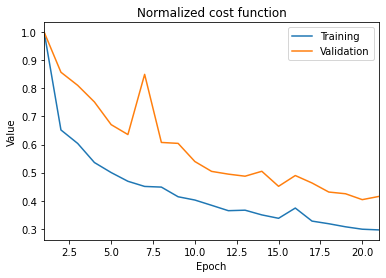

In [14]:
plt.plot(np.linspace(1,EPOCHS,EPOCHS),model_history.history["loss"]/np.max(model_history.history["loss"]),label="Training")
plt.plot(np.linspace(1,EPOCHS,EPOCHS),model_history.history["val_loss"]/np.max(model_history.history["val_loss"]),label="Validation")
plt.xlim([1,EPOCHS])
# plt.ylim([0, 1.1])
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.title("Normalized cost function")
plt.savefig("fig/LSMNet_v2_cost_func.png")

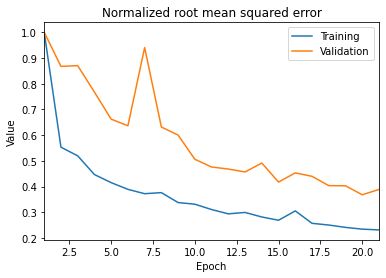

In [15]:
plt.plot(np.linspace(1,EPOCHS,EPOCHS),model_history.history["root_mean_squared_error"]/np.max(model_history.history["root_mean_squared_error"]),label="Training")
plt.plot(np.linspace(1,EPOCHS,EPOCHS),model_history.history["val_root_mean_squared_error"]/np.max(model_history.history["val_root_mean_squared_error"]),label="Validation")
plt.xlim([1,EPOCHS])
# plt.ylim([0, 1.1])
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.title("Normalized root mean squared error")
plt.savefig("fig/LSMNet_v2_rms_error.png")

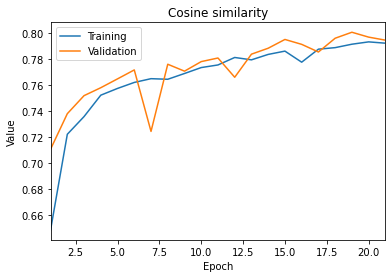

In [16]:
plt.plot(np.linspace(1,EPOCHS,EPOCHS),model_history.history["cosine_similarity"],label="Training")
plt.plot(np.linspace(1,EPOCHS,EPOCHS),model_history.history["val_cosine_similarity"],label="Validation")
plt.xlim([1,EPOCHS])
#plt.ylim([0, 1.1])
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.title("Cosine similarity")
plt.savefig("fig/LSMNet_v2_cosine_similarity.png")

In [17]:
# reload the model and history for checking
model = tf.keras.models.load_model(prefix0+'LSMNet_v2')
model_history_npy = np.load(prefix0+'LSMNet_v2_history.npy',allow_pickle='TRUE').item()